In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model

from sklearn.metrics import mean_absolute_percentage_error

np.random.seed(123)
tf.random.set_seed(123)

In [22]:
# Get data
df = pd.read_csv("../Data/airline_passengers.csv",
                 index_col = 'Month',
                 parse_dates = True)
df.head()
df.index.freq = 'MS'

# Log transform
df['LogPassengers'] = np.log(df['Passengers'])

df['DiffLogPassengers'] = df['LogPassengers'].diff()

series = df['DiffLogPassengers'].dropna().to_numpy()

# SPlit test and train
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

# Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

# Create AR like data
T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t: t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
# Reshape Data D = 1 in this case
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
print(X.shape, Y.shape)
N = len(X)

(133, 10, 1) (133,)


In [23]:
# Split train and test
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [24]:
# CNN
i = Input(shape = (T, 1))
x = Conv1D(16, 3, activation = 'relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)
model = Model(i, x)

In [25]:
model.summary()

# input_3 (InputLayer) [(None, 10, 1)] Meaning that 10 time series values with 1Dimentional

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 8, 16)             64        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 4, 16)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 32)             1568      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)                 33  

In [26]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

r = model.fit(
    Xtrain,
    Ytrain,
    epochs = 100,
    validation_data = (Xtest, Ytest)
    )

Epoch 1/100
4/4 [==============================] - 0s 50ms/step - loss: 0.0122 - val_loss: 0.0112
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 11/100
4/4 [=

Epoch 83/100
4/4 [==============================] - 0s 11ms/step - loss: 8.2498e-04 - val_loss: 0.0040
Epoch 84/100
4/4 [==============================] - 0s 11ms/step - loss: 8.4059e-04 - val_loss: 0.0040
Epoch 85/100
4/4 [==============================] - 0s 12ms/step - loss: 8.2431e-04 - val_loss: 0.0041
Epoch 86/100
4/4 [==============================] - 0s 11ms/step - loss: 8.1630e-04 - val_loss: 0.0040
Epoch 87/100
4/4 [==============================] - 0s 13ms/step - loss: 8.0326e-04 - val_loss: 0.0041
Epoch 88/100
4/4 [==============================] - 0s 12ms/step - loss: 7.9842e-04 - val_loss: 0.0041
Epoch 89/100
4/4 [==============================] - 0s 10ms/step - loss: 8.0429e-04 - val_loss: 0.0041
Epoch 90/100
4/4 [==============================] - 0s 11ms/step - loss: 7.8153e-04 - val_loss: 0.0042
Epoch 91/100
4/4 [==============================] - 0s 11ms/step - loss: 8.2700e-04 - val_loss: 0.0040
Epoch 92/100
4/4 [==============================] - 0s 11ms/step - loss: 

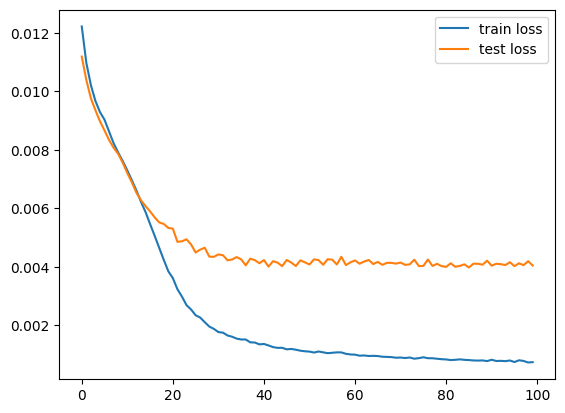

In [27]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

1/1 [==============================] - 0s 23ms/step


<Axes: xlabel='Month'>

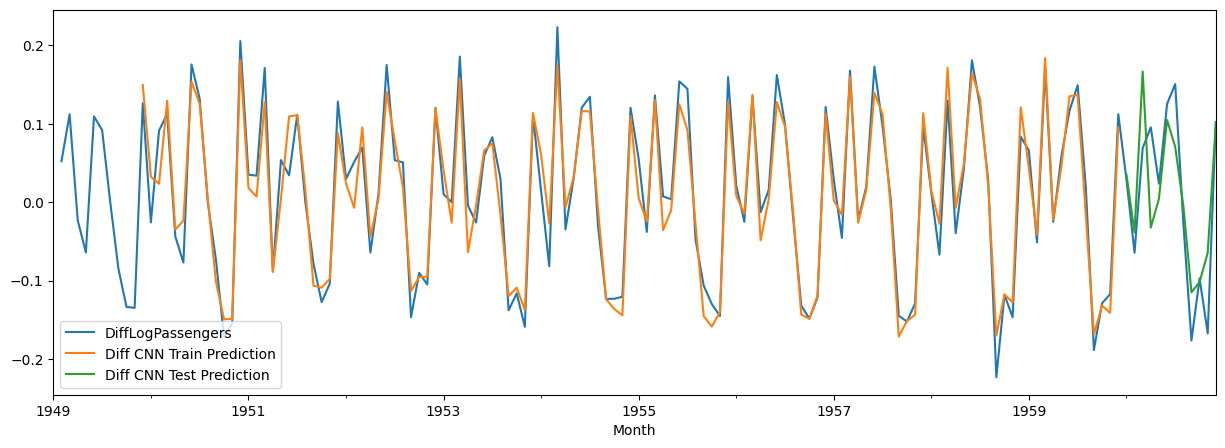

In [28]:
train_idx[:T+1] = False

Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

# Store diff predictions
df.loc[train_idx, 'Diff CNN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff CNN Test Prediction'] = Ptest

# Plot the result
cols = ['DiffLogPassengers',
       'Diff CNN Train Prediction',
       'Diff CNN Test Prediction']
df[cols].plot(figsize = (15,5))


# 1 step forecast

<Axes: xlabel='Month'>

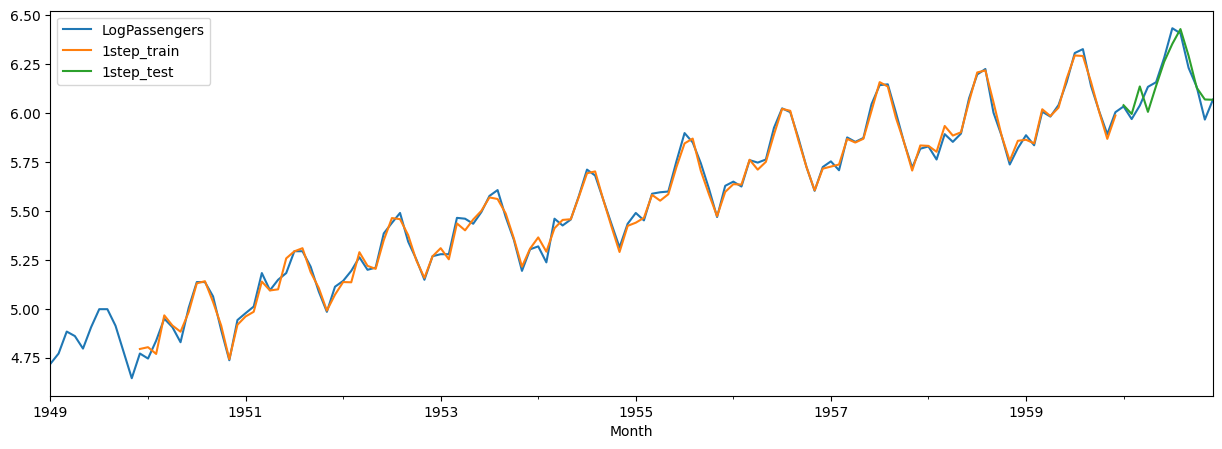

In [29]:
# undifference
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

# Last-Known train vlaue
last_train = train.iloc[-1]['LogPassengers']

# 1-step forecast
df.loc[train_idx, "1step_train"] = prev[train_idx] + Ptrain
df.loc[test_idx, "1step_test"] = prev[test_idx] + Ptest

# Plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize = (15, 5))

# Multistep forecast

1/1 [==============================] - 0s 11ms/step


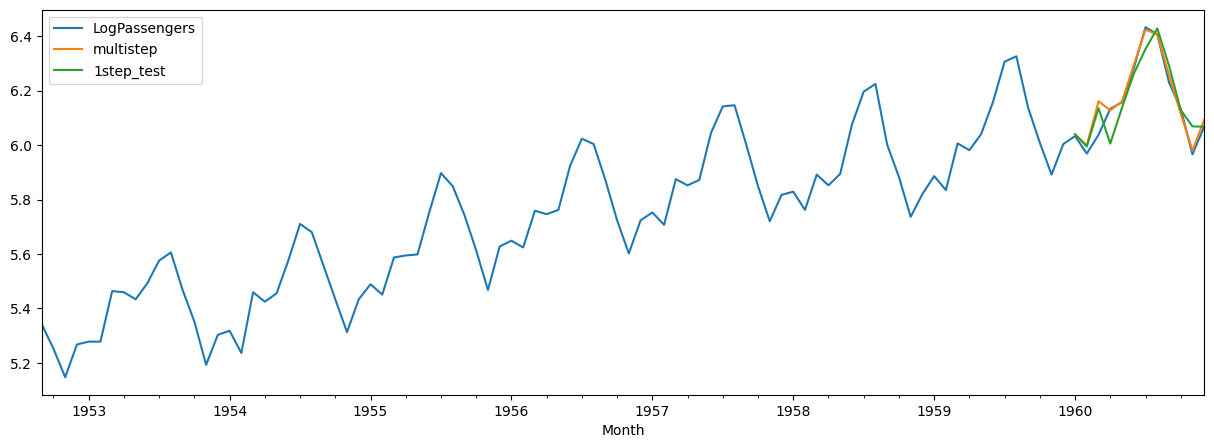

In [32]:
# Multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1, 1))[0]
    
    multistep_predictions.append(p)
    
    last_x = np.roll(last_x,-1) # [1,2,3] -> [2,3,1]
    last_x[-1] = p # Replace the last value with the predicted value

# Save prediction
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

# plot 1-step, multistep forecast
df.iloc[-100:][['LogPassengers', 'multistep', '1step_test']].plot(figsize = (15, 5));

# multi output forcast

In [33]:
# Create AR like data
Tx = T
Ty = Ntest
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t: t+Tx]
    X.append(x)
    
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)
    

# Reshape Data
X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print('X.shape', X.shape, 'Y.shpae', Y.shape)

X.shape (122, 10, 1) Y.shpae (122, 12)


Epoch 1/200
4/4 [==============================] - 0s 86ms/step - loss: 0.0125 - val_loss: 0.0141
Epoch 2/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0117 - val_loss: 0.0129
Epoch 3/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0113 - val_loss: 0.0122
Epoch 4/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0111 - val_loss: 0.0117
Epoch 5/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0109 - val_loss: 0.0113
Epoch 6/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 7/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0105 - val_loss: 0.0106
Epoch 8/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 9/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 10/200
4/4 [==============================] - 0s 42ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 11/200
4/4 [=

Epoch 84/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 85/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 86/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 87/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 88/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 89/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 90/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 91/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 92/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 93/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 94/2

4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 167/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 168/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 169/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 170/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 171/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 172/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 173/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 174/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 175/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 176/200


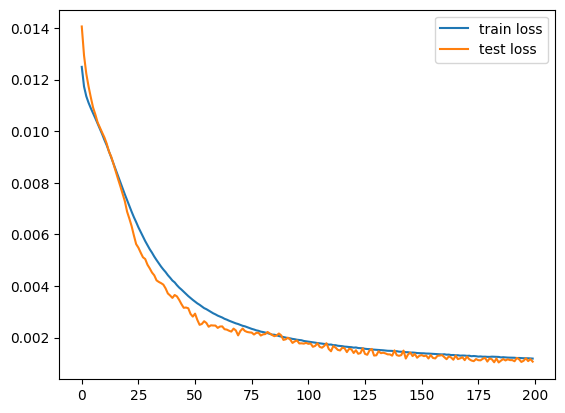

In [35]:
# Split train and test
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

# CNN
i = Input(shape = (Tx, 1))
x = Conv1D(16, 3, activation = 'relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

model.compile(
    loss = 'mse',
    optimizer = 'adam',
)

r = model.fit(
    Xtrain_m,
    Ytrain_m,
    epochs = 200,
    validation_data = (Xtest_m, Ytest_m)
)

plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

1/1 [==============================] - 0s 24ms/step


<Axes: xlabel='Month'>

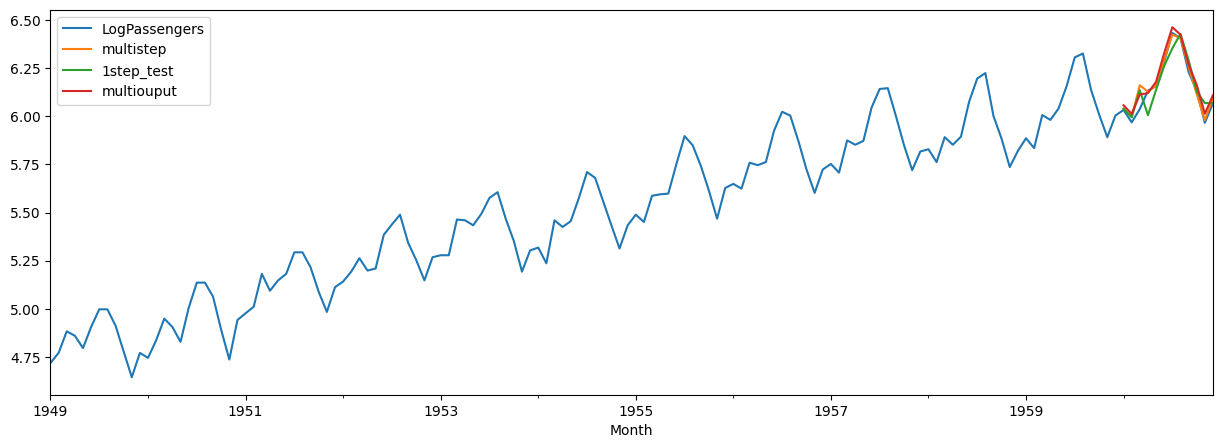

In [36]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

# AR like X values arel ike [y1 y2 y3] , [y2, y3, y4], so take the first col only
Ptrain = Ptrain[:,0] 
Ptest = Ptest[0]

# Store diff predictions
df.loc[test_idx, 'multiouput'] = last_train + np.cumsum(Ptest)

# Plot the result
cols = ['LogPassengers',
        'multistep', 
        '1step_test',
       'multiouput']
df[cols].plot(figsize = (15,5))


In [39]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print("multistep: ", mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multiouput'])
print("multioutput: ", mape2)

multistep:  0.0037539337396450567
multioutput:  0.005845465798826863
